In [17]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py
import pandas as pd
import random
#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (10,6)

### Setup

we chose the LHC data last week. In order to make a fake background I decided to generate 100,000 random poisson distributed numbers using rvs with $\mu =100$. This will be the makeshift LHC background data, which is the number of particle counts that are not considered to be a signal.

In [2]:
#background
background = stats.poisson.rvs(100, size=100000)

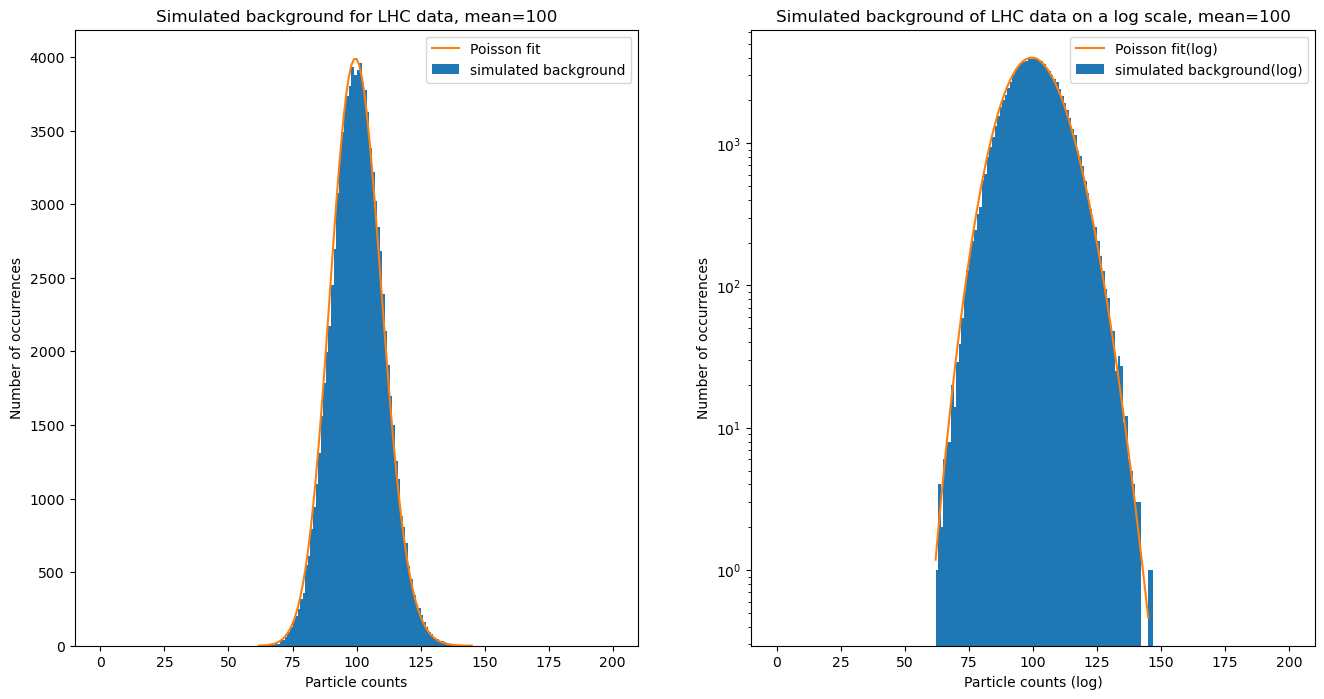

In [3]:
x = np.arange(background.min(), background.max())
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].set_title('Simulated background for LHC data, mean=100')
ax[0].set_xlabel('Particle counts')
ax[0].set_ylabel('Number of occurrences')
ax[0].hist(background, bins=np.arange(0, 201), width=1, label= 'simulated background');
ax[0].plot(x, 100000*stats.poisson.pmf(x, 100), label='Poisson fit')
ax[0].legend()
ax[1].set_title('Simulated background of LHC data on a log scale, mean=100')
ax[1].set_xlabel('Particle counts (log)')
ax[1].set_ylabel('Number of occurrences')
ax[1].set_yscale('log')
ax[1].hist(background, bins=np.arange(0, 201), width=1, label='simulated background(log)');
ax[1].plot(x, 100000*stats.poisson.pmf(x, 100), label='Poisson fit(log)')
ax[1].legend();

### Problem 1
Find the 5-sigma sensitivity threshold.

The probability of a 5-sigma event for a standard normal distribution can be calculated by norm.sf(5). Then we can calculated the value associated to a 5-sigma event for a poisson distribution with a mean around 100.

In [6]:
#using stats.norm.sf to get the probability of measuring 5sigma or greater of a Gaussian
prob_5sigma = stats.norm.sf(5)

#using stats.poisson.isf and stats.poisson.ppf to get the upper and lower limits, respectively of the 5sigma threshold on the background distribution
upper_threshold = stats.poisson.isf(prob_5sigma, 100)
lower_threshold = stats.poisson.ppf(prob_5sigma, 100)
print('The upper limit of 5 sigma theshold is {} and the lower limit of 5 sigma threshold is {} for the LHC background.'.format(upper_threshold, lower_threshold))

The upper limit of 5 sigma theshold is 154.0 and the lower limit of 5 sigma threshold is 54.0 for the LHC background.


### Problem 2
Now inject a signal of known strength. You will want to make your signal moderately strong, say somewhere in the 8-30σ range. Inject this signal into your background data many times.

a) Histogram how bright the observed signal appears to be, and discuss it's shape. Say in words what this histogram is telling you.

b) Is your observed signal biased? (e.g. is the observed value equally likely to be stronger or weaker than the true injected signal?) Is it symmetric?

#### Q2.a
Histogram how bright the observed signal appears to be, and discuss it's shape. Say in words what this histogram is telling you.

In [46]:
#finding the 8 sigma threshold
prob_8sigma = stats.norm.sf(8)
threshold = stats.poisson.isf(prob_8sigma, 100)
print('The 8 sigma value of this distribution is {}'.format(threshold))

The 8 sigma value of this distribution is 190.0


We now need to generate the signal which will also be counting particle events. Hence, our signal will also be Poisson distributed. Therefore, we will just pick 190 as the mean value for the signal jections.

In [47]:
signal_mean = 190
signal = stats.poisson.rvs(signal_mean,size=100000)

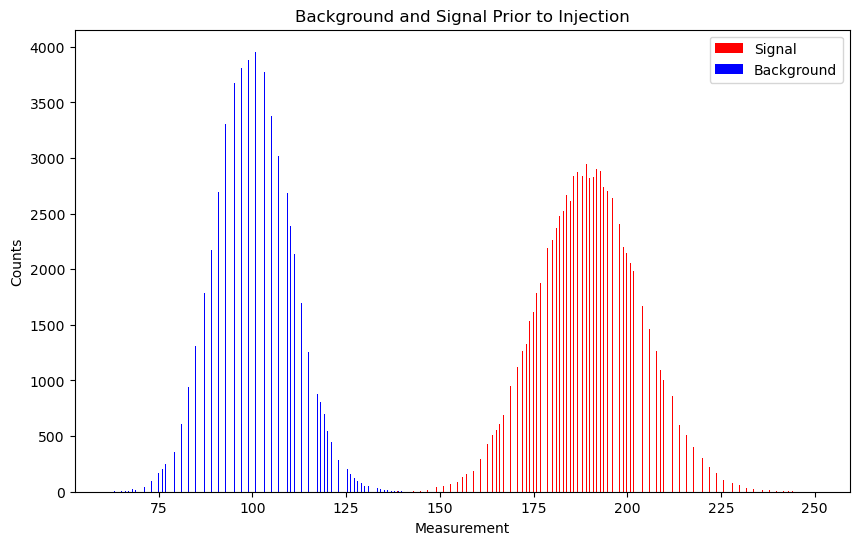

In [48]:
plt.hist([signal, background], bins =400, color=['red','blue'],label=['Signal', 'Background'])
plt.title("Background and Signal Prior to Injection")
plt.xlabel("Measurement")
plt.ylabel("Counts")
plt.legend()
plt.show()

As we can see from the above plot, there is a very little overlap between the two distributions and the signal are very obvious. Let's see what happens when we inject the signal into our background.

#### Q2.b
b) Is your observed signal biased? (e.g. is the observed value equally likely to be stronger or weaker than the true injected signal?) Is it symmetric?

In [49]:
#combining observed signal and background
mixed = np.zeros(background.size)
for i in range(mixed.size):
    if i < signal.size:
        mixed[i] = np.add(background[i], signal[i])
    else:
        mixed[i] = background[i]

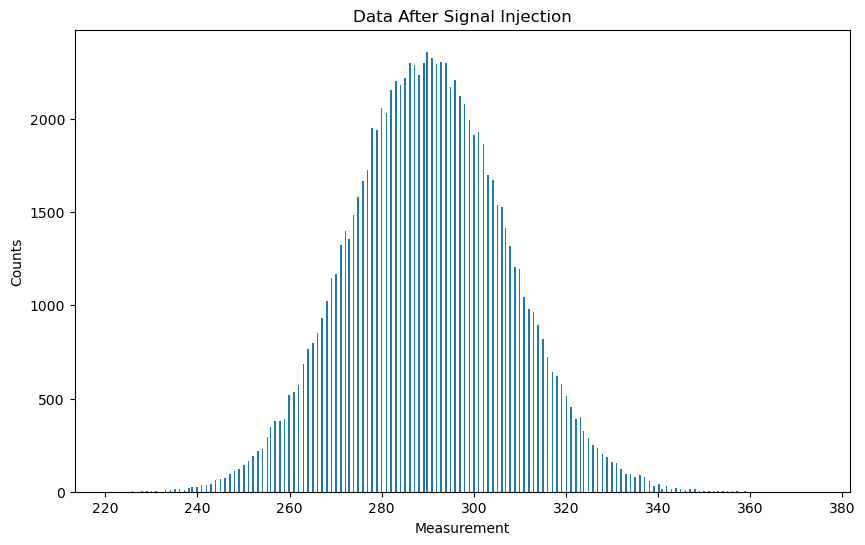

In [50]:
plt.hist(mixed,bins = 450)
plt.title('Data After Signal Injection')
plt.xlabel('Measurement')
plt.ylabel('Counts')
plt.show()

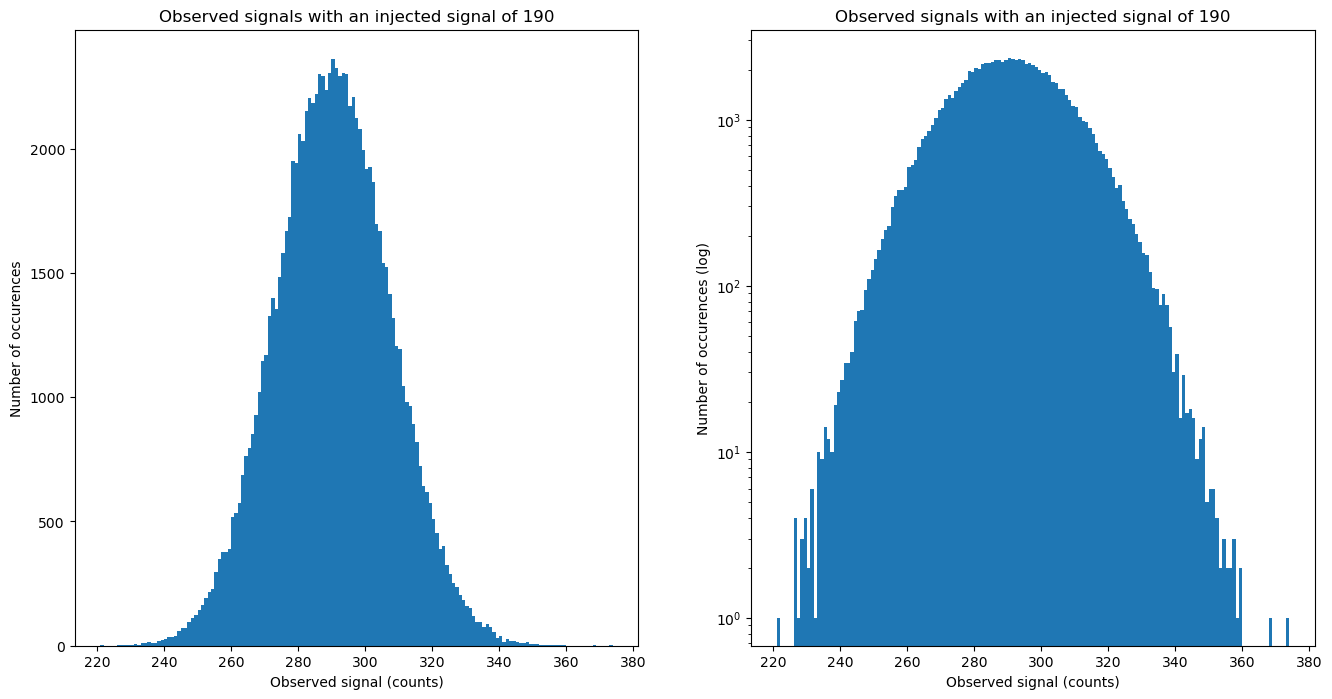

In [51]:
# making a plot for the new data which include observed signal and background
k = np.arange(mixed.min(), mixed.max())
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].set_title('Observed signals with an injected signal of 190')
ax[0].set_xlabel('Observed signal (counts)')
ax[0].set_ylabel('Number of occurences')
ax[0].hist(mixed, bins=len(k))
ax[1].set_title('Observed signals with an injected signal of 190')
ax[1].set_xlabel('Observed signal (counts)')
ax[1].set_ylabel('Number of occurences (log)')
ax[1].hist(mixed, bins=len(k))
ax[1].set_yscale('log');

In [58]:
print('The mean of the combined dataset is {}'.format(np.mean(mixed)))

The mean of the combined dataset is 290.08974


In [53]:
#printing the 5th and 95th percentile bounds - the mean to see how symmetric the distribution is
print(np.quantile(mixed, 0.05)-290)
print(np.quantile(mixed, 0.95)-290)

-28.0
28.0


Since the mean of the observed signal is about 290, and the injected signal is 190, the observed signal is biased by the mean of the background distribution, 100. The observed signal is approximately symmetric, since the 5th percentile and the 95th percentile values are 28 and 28 counts away from the mean as we claculated above. On the other hand, by justing looking the plot itself, the regular distribution looks very symmetric, and the log plot seems symmetric. In fact, this distribution is the same as the original background distribtution. Moreover, due to the central limit theorem, the signal should look like gaussian. Thus, for the large sample size I have, it seems symmetric.

### Problem 3
Now make a suite of injected signals. You will want to have a range of injected signal strengths, starting at zero and extending well above 5σ (30σ or more). You will want to follow the work you did for Homework 5 very closely.

a) Clearly state what you are simulating, and make a 2D histogram of injected signal vs. observed data

b) For the same injected signal power as in problem 2, show that you get the same answer.

c) Now reverse the problem, select an observed data value (pick something quite a bit stronger than 5σ) and create a 1D histogram of the true signal probability given the observed data. Describe the meaning of this histogram.

d) For your observed signal, what is the 1σ uncertainty on the true signal strength?

e) Discuss the answer to part d in some depth. Is it symmetric? Is it biased? Does this make sense?

#### Q3.a
Clearly state what you are simulating, and make a 2D histogram of injected signal vs. observed data

The strongest relationship can be observed right along the diagonal for an injected signal to show up. Taking and analyzing a sample point it seems that the offset between the injected signal and the observed signal is 100. Which is the value of the mean of our poisson background distribution.

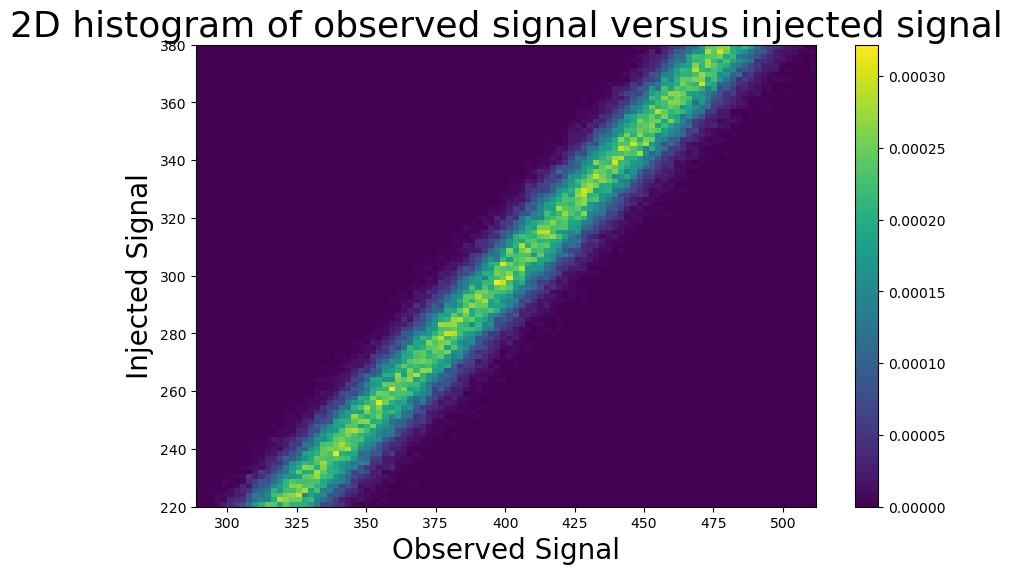

In [72]:
noise = stats.poisson.rvs(mu=100, size=100000)
injection = np.linspace(220,380,100000)

observed = noise + injection

h = plt.hist2d(observed, injection, bins = (100,100), density=True)
plt.colorbar(h[3])
plt.ylabel("Injected Signal", fontsize = "20")
plt.xlabel("Observed Signal", fontsize = "20")
plt.title("2D histogram of observed signal versus injected signal", fontsize = "26")
plt.show()

#### Q3.b
In order to check with the previous result, we sample from the background many times and add to each sampled value the mean of the signal we had in the previously (190).

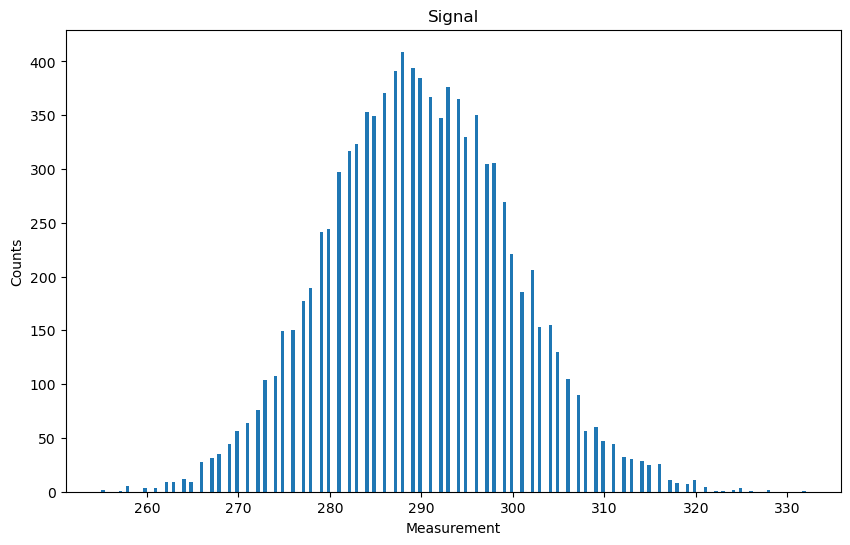

In [74]:
a1 = stats.poisson.rvs(100, size = 10000)
b1 = np.array([])
signal = 190
for i in a1:
    b1 = np.append(b1, i + signal)
    
plt.hist(b1, bins = 200)
plt.title('Signal')
plt.xlabel('Measurement')
plt.ylabel('Counts')
plt.show()

We see a Poisson distribution with a mean of 290, which is what we had before.

#### Q.3c
Now reverse the problem, select an observed data value (pick something quite a bit stronger than 5σ) and create a 1D histogram of the true signal probability given the observed data. Describe the meaning of this histogram.
 
Now we reverse, so we want to know what the original injected signal was from the observed one. We saw from previous questions that they only were offset by the mean, so we can subtract the background, then we can get the signal.

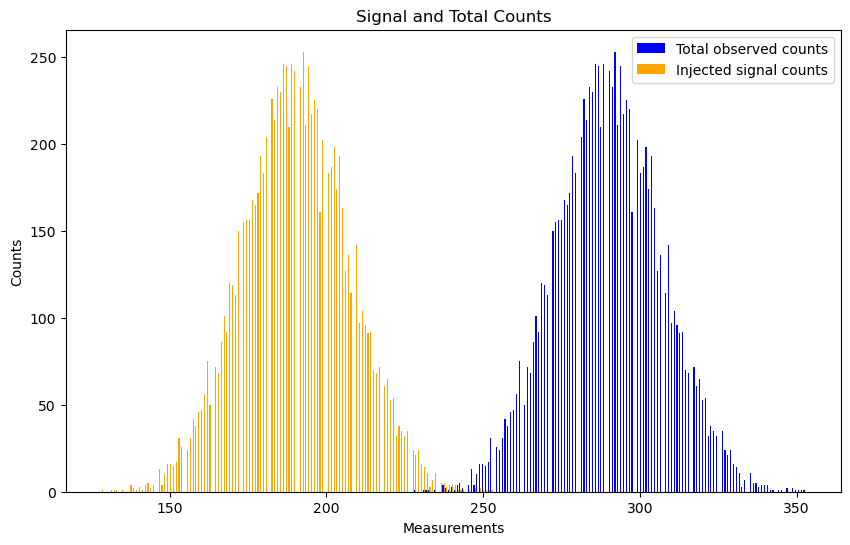

In [78]:
obs_mean = 290
bg_mean = 100
new_sample = stats.poisson.rvs(obs_mean, size=10000)
al = np.array([])
for i in new_sample:
    al = np.append(al, i - bg_mean)
    
plt.hist([new_sample, al], bins = 250, color=['blue', 'orange'], label=['Total observed counts', 'Injected signal counts'])
plt.title('Signal and Total Counts')
plt.xlabel('Measurements')
plt.ylabel('Counts')
plt.legend()
plt.show()

We can confirm again that these distributions look very similar as previous distributions. The injected signal distribution is independent of the background, it is made from the signal alone and without contribution from the background.

#### Q3.d and Q3.e
d) For your observed signal, what is the 1σ uncertainty on the true signal strength?

e) Discuss the answer to part d in some depth. Is it symmetric? Is it biased? Does this make sense?

We start by normalizing to obtain a pdf. Then we can integrate it from the mean to the 1 sigma probability on both sides. In our case the center is 190.

In [83]:
print(new_sample.mean())
print(stats.mode(new_sample))

290.0508
ModeResult(mode=array([292]), count=array([253]))


In [84]:
#finding the upper and lower limits of 1 sigma for the observed signal of 500 by using np.qunatile
sigma_upper = np.quantile(new_sample, 0.84)
sigma_lower = np.quantile(new_sample, 0.16)
print('The 1 sigma uncertainty of the injected signal is {} to {} particle counts.'.format(sigma_lower, sigma_upper))

The 1 sigma uncertainty of the injected signal is 273.0 to 307.0 particle counts.


In [86]:
(sigma_upper+sigma_lower)/2

290.0

In [85]:
#finding the 5 sigma threshold
sigma_5upper = np.quantile(new_sample, 1-prob_5sigma)
sigma_5lower = np.quantile(new_sample, prob_5sigma)
print(sigma_5lower)
print(sigma_5upper)

228.00859868720167
352.9971337709321


In [87]:
(sigma_5upper+sigma_5lower)/2

290.5028662290669

The distribution is biased, because an observed signal of 290 has a distribution of injected signals centered at 190, which is less than the mean of background. The observed signal is always going to be higher than the true, injected signal. Because the 1$\sigma$ thresholds are an equal distance from the mean, at first it would appear that the distribution is symmetric, however bringing it out to 5$\sigma$ shows that it is not. The 5$\sigma$ threshold values are not exactly centered at 290.0, and thus the distribtution is not entrily symmetric. That makes sense since we start with a poisson distribution. Moreover, because of the central limit theorem, as we making our dataset larger and larger, our data would get closer and closer to Guassian distribution which is symmetric.  